In [1]:
using LinearAlgebra, Convex, ECOS, Plots
solver = ECOS.Optimizer(verbose=false)

ECOS.Optimizer

In [2]:
kbc = include("KinematicBicycleCar.jl")

KinematicBicycleCar(5, 2, 2.67, 2.1, [-5.0, 1.0], [-0.7853981633974483, 0.7853981633974483], linearizeKinematicBicycleCar, simulateKinematicBicycleCar)

# Baseline MPC problem
We want to establish a baseline to compare new problem formulations with.
This is a standard MPC problem: come up with a control signal u to minimize quadratic cost along said trajectory.
We have box limits on u.

The problem is <a href=https://stanford.edu/class/ee364b/lectures/mpc_slides.pdf>(source)</a>:
\begin{align*}
\text{minimize} &\quad z_N^TQ_Nz_N + \sum_{i=0}^{N-1}z_i^TQz_i + u_i^TRu_i
\\
\text{subject to} &\quad u_i \in \mathcal{U}\ \forall\ i=1,\dots,N-1
\\
&\quad z_i \in \mathcal{z}\ \forall\  i=1,\dots,N
\\
&\quad z_{i+1} = Az_i + Bu_i\ \forall\ i=1,\dots,N-1
\\
&\quad z_T = 0
\end{align*}
with variables $z_1,\dots,z_N\ \in \mathbb{R}^n$ and $u_1,\dots,u_{N-1}\ \in \mathbb{R}^m$
and parameters $Q, Q_N\in \mathbb{R}^{n\times n},\ R \in \mathbb{R}^{n\times m}$.
<br>
We have an optional fixed final state $z_T = 0$.
<br>
The sets $\mathcal{X}$ and $\mathcal{U}$ are convex. In fact, they are boxes.

We want to make an MPC tracking problem: given a set of knot points along the trajectory, compute the control and states that keep us close to that trajectory.

## MPC tracking formulation.
Then the variable is the error, $z_i - z_{ref,i} = \delta z_i$ and $u_i - u_{ref,i} = \delta u_i$, Since for the reference trajectory, $z_{ref, i+1} = Az_{ref,i} + Bu_{ref, i}$:
$$\delta z_{i+1} = z_{i+1} - z_{ref, i+1} = A(z_i-z_{ref, i}) + B(u_i-u_{ref,i})$$

\begin{align*}
\text{minimize} &\quad \delta z_N^TQ_N\delta z_N + \sum_{i=0}^{N-1}\delta z_i^TQ\delta z_i + \delta u_i^TR\delta u_i
\\
\text{subject to} &\quad \delta u_i + u_{ref,i} \in \mathcal{U}\ \forall\ i=1,\dots,N-1
\\
&\quad \delta z_i+z_{ref,i}\in \mathcal{z}\ \forall\  i=1,\dots,N
\\
&\quad \delta z_{i+1} = A\delta z_i + B\delta u_i\ \forall\ i=1,\dots,N-1
\\
&\quad \delta z_T = 0
\end{align*}

Concatenate all the z's and all the u's into $Z \in \mathbb{R}^{nT}$ and $U \in \mathbb{R}^{m(T-1)}$. Then, using the dynamics constraint:
$z_2 = A_1z_1 + B_1u_1$,...
<br>
$$z_{k+1} = A_kz_k + B_ku_k$$

The initial state $z_1$ is known.

The state $Z$ in terms of $U$ is:

\begin{gather*}
\begin{bmatrix}z_2\\\vdots\\z_N\end{bmatrix} =
\begin{bmatrix}A_1 & 0 & 0\\
0 & \ddots & 0\\
0 & 0 & A_{N-1}\end{bmatrix}
\begin{bmatrix}z_1\\\vdots\\z_{N-1}\end{bmatrix} +
\begin{bmatrix}B_1 & 0 & 0\\
0 & \ddots & 0\\
0 & 0 & B_{N-1}\end{bmatrix}
\begin{bmatrix}u_1\\\vdots\\u_{N-1}\end{bmatrix}
\\
0 =
\begin{bmatrix}A_1 & -I & \dots & 0\\
0 & \ddots & \ddots & \vdots \\
0 & 0 & A_{N-1} & -I\end{bmatrix}
\begin{bmatrix}z_1\\\vdots\\z_{N-1}\\z_N\end{bmatrix} +
\begin{bmatrix}B_1 & 0 & 0\\
0 & \ddots & 0\\
0 & 0 & B_{N-1}\end{bmatrix}
\begin{bmatrix}u_1\\\vdots\\u_{N-1}\end{bmatrix}
\\
0 = \bar{A}Z + \bar{B}U
\end{gather*}

Then the cost $J = z_n^TQ_Nz_N + \sum_{i=0}^{N-1} z_i^TQz_i + u_i^TRu_i$ becomes $Z^T\bar{Q}Z + U^T\bar{R}U$, where $\bar{Q}$ is a matrix with $N-1$ diagonal blocks $Q$ and the last one $Q_N$.

\begin{equation*}
\bar{Q} = \begin{bmatrix}Q & 0 & \dots & 0\\
0 & \ddots & \ddots & \vdots\\
\vdots & \ddots & Q & 0
\\
0 & \dots & 0 & Q_N\end{bmatrix}
,\quad
\bar{R} = \begin{bmatrix}R & 0 & 0\\
0 & \ddots & 0\\
0 & 0 & R\end{bmatrix}
\end{equation*}

\begin{align*}
J &= Z^T\bar{Q}Z + U^T\bar{R}U
\end{align*}


[1.0, 1.0]
[1.0, 1.01]
[1.0, 1.01999]
[1.0, 1.02997]
[1.0, 1.03994]
[1.0, 1.0499]
[1.0, 1.05985]
[1.0, 1.06979]
[1.0, 1.07972]
[1.0, 1.08964]
[1.0, 1.09955]
[1.0, 1.10945]
[1.0, 1.11934]
[1.0, 1.1292200000000001]
[1.0, 1.1390900000000002]
[1.0, 1.1489500000000001]
[1.0, 1.1588]
[1.0, 1.1686400000000001]
[1.0, 1.1784700000000001]
[1.0, 1.18829]
[1.0, 1.1981000000000002]
[1.0, 1.2079000000000002]
[1.0, 1.2176900000000002]
[1.0, 1.22747]
[1.0, 1.2372400000000001]
[1.0, 1.247]
[1.0, 1.25675]
[1.0, 1.2664900000000001]
[1.0, 1.2762200000000001]
[1.0, 1.28594]
[1.0, 1.2956500000000002]
[1.0, 1.3053500000000002]
[1.0, 1.3150400000000002]
[1.0, 1.3247200000000001]
[1.0, 1.3343900000000002]
[1.0, 1.3440500000000002]
[1.0, 1.3537000000000001]
[1.0, 1.3633400000000002]
[1.0, 1.3729700000000002]
[1.0, 1.3825900000000002]
[1.0, 1.3922]
[1.0, 1.4018000000000002]
[1.0, 1.4113900000000001]
[1.0, 1.42097]
[1.0, 1.4305400000000001]
[1.0, 1.4401000000000002]
[1.0, 1.44965]
[1.0, 1.4591900000000002]
[1.0, 

[1.0, 4.717219999999998]
[1.0, 4.722289999999998]
[1.0, 4.727349999999999]
[1.0, 4.732399999999998]
[1.0, 4.7374399999999985]
[1.0, 4.742469999999998]
[1.0, 4.747489999999998]
[1.0, 4.752499999999999]
[1.0, 4.7574999999999985]
[1.0, 4.762489999999999]
[1.0, 4.7674699999999985]
[1.0, 4.772439999999999]
[1.0, 4.777399999999998]
[1.0, 4.782349999999998]
[1.0, 4.787289999999999]
[1.0, 4.792219999999999]
[1.0, 4.797139999999999]
[1.0, 4.802049999999999]
[1.0, 4.806949999999999]
[1.0, 4.811839999999998]
[1.0, 4.816719999999998]
[1.0, 4.821589999999999]
[1.0, 4.826449999999999]
[1.0, 4.831299999999999]
[1.0, 4.8361399999999986]
[1.0, 4.840969999999999]
[1.0, 4.845789999999998]
[1.0, 4.850599999999998]
[1.0, 4.855399999999999]
[1.0, 4.8601899999999985]
[1.0, 4.864969999999999]
[1.0, 4.869739999999998]
[1.0, 4.8744999999999985]
[1.0, 4.879249999999998]
[1.0, 4.883989999999998]
[1.0, 4.888719999999998]
[1.0, 4.893439999999998]
[1.0, 4.8981499999999984]
[1.0, 4.902849999999998]
[1.0, 4.9075399999

[1.0, 5.955499999999997]
[1.0, 5.956489999999997]
[1.0, 5.957469999999997]
[1.0, 5.958439999999997]
[1.0, 5.959399999999997]
[1.0, 5.9603499999999965]
[1.0, 5.961289999999996]
[1.0, 5.962219999999997]
[1.0, 5.9631399999999966]
[1.0, 5.964049999999997]
[1.0, 5.964949999999996]
[1.0, 5.9658399999999965]
[1.0, 5.966719999999997]
[1.0, 5.967589999999997]
[1.0, 5.968449999999997]
[1.0, 5.969299999999997]
[1.0, 5.970139999999997]
[1.0, 5.970969999999997]
[1.0, 5.971789999999997]
[1.0, 5.972599999999997]
[1.0, 5.973399999999997]
[1.0, 5.9741899999999974]
[1.0, 5.974969999999997]
[1.0, 5.975739999999997]
[1.0, 5.976499999999997]
[1.0, 5.977249999999997]
[1.0, 5.9779899999999975]
[1.0, 5.978719999999997]
[1.0, 5.979439999999998]
[1.0, 5.980149999999997]
[1.0, 5.980849999999998]
[1.0, 5.981539999999997]
[1.0, 5.982219999999997]
[1.0, 5.982889999999998]
[1.0, 5.9835499999999975]
[1.0, 5.984199999999998]
[1.0, 5.9848399999999975]
[1.0, 5.985469999999998]
[1.0, 5.986089999999997]
[1.0, 5.9866999999

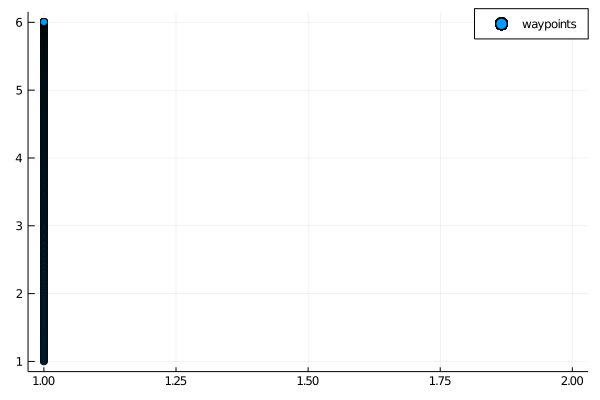

In [19]:
# OK let's make some paths with waypoints:
# 1. Straight path, smoothly decelerating to a stop for 10 seconds.
Δt = 0.01 # seconds
N = 25
# timestep is 0.01 s, in agreement with this paper, and horizon is 25 steps.
# https://www.diva-portal.org/smash/get/diva2:860675/FULLTEXT01.pdf (page 50)
# Model Complexity and Coupling of Longitudinal and Lateral Control in Autonomous Vehicles Using Model Predictive Control

straight_stop = zeros(Integer(10/Δt)*5,1)

a = -0.1 # m/s
v = 1.0  # m/s 
straight_stop[1:5] = [1,1,v,0,0]
for i=2:Integer(10/Δt)
    x = 1.0 # fixed
    y = straight_stop[(i-2)*5+2] + v*Δt
    v = v + a*Δt
    straight_stop[(i-1)*5+1:(i-1)*5+3] = [x,y,v]
end

straight_stop[end-2] = 0.0 # explicitly force 0 velocity at end.

waypoints = zeros(Integer(length(straight_stop)/kbc.n),2)

for i=1:Integer(length(straight_stop)/kbc.n)
    waypoints[i,:] = straight_stop[(i-1)*kbc.n+1:(i-1)*kbc.n+2]
    println(waypoints[i,:])
end
scatter(waypoints[:,1], waypoints[:,2], label="waypoints")

In [4]:
Q = I(5)
Q_N = Q*10;
R = I(2)
Q_bar = zeros(5*N, 5*N)
R_bar = I(2*(N-1))
for i=1:N-1
Q_bar[1+(i-1)*5:i*5, 1+(i-1)*5:i*5] = Q
end
Q_bar[end-4:end, end-4:end] = Q_N

# OK now the cost matrices and big versions are constructed.

5×5 Diagonal{Int64,Array{Int64,1}}:
 10   ⋅   ⋅   ⋅   ⋅
  ⋅  10   ⋅   ⋅   ⋅
  ⋅   ⋅  10   ⋅   ⋅
  ⋅   ⋅   ⋅  10   ⋅
  ⋅   ⋅   ⋅   ⋅  10

In [16]:
function mpc_step(car, z₀::Array{Float64}, u₀::Array{Float64}, waypoints::Array{Float64}; N=25)
    Z = Convex.Variable( N   *car.n, 1)
    U = Convex.Variable((N-1)*car.m, 1)
    
    J = quadform(Z, Q_bar) + quadform(U, R_bar)
    
    # Construct the time-dependent linearized dynamics
    A_bar = zeros((N-1)*car.n, N*car.n)
    B_bar = zeros((N-1)*car.n, (N-1)*car.m)
    
    for k=1:N-1
        Aₖ, Bₖ = car.linearize(car, z₀[(k-1)*kbc.n+1:k*kbc.n], u₀[(k-1)*kbc.m+1:k*kbc.m])
        A_bar[1+(k-1)*car.n:k*car.n, 1+(k-1)*car.n:(k+1)*car.n] = hcat(Aₖ, -I)
        B_bar[1+(k-1)*car.n:k*car.n, 1+(k-1)*car.m:k*car.m] = Bₖ
    end

    # OK so we have waypoints.
    constraints = [
        0 == A_bar * Z + B_bar * U,
        Z[end-4:end-2] + z₀[end-4:end-2] ==  waypoints[end-4:end-2],
        U + u₀ >= repeat([car.a_limit[1]; car.δf_limit[1]], N-1, 1),
        U + u₀ <= repeat([car.a_limit[2]; car.δf_limit[1]], N-1, 1),
    ]
    
    problem = minimize(J, constraints)
    Convex.solve!(problem, solver, verbose=false)
    
    println("Solved MPC run with cost ", problem.optval, " and status ", problem.status)
    #println("X\n", X.value)
    #println("U\n", U.value)
    return Z.value, U.value
end


mpc_step (generic function with 1 method)

In [22]:
t = 1

Z_all = straight_stop
U_all = zeros(length(straight_stop)-kbc.m,1)

while t + N < length(straight_stop)/kbc.n
    Z = Z_all[(t-1)*kbc.n+1:(t-1+N)*kbc.n]
    U = U_all[(t-1)*kbc.m+1:(t-2+N)*kbc.m]
    
    Z₊, U₊ = mpc_step(kbc, Z, U, straight_stop[(t-1)*kbc.n+1:(t-1+N)*kbc.n])
    zₜ = kbc.simulate(Z[1:kbc.n]+Z₊[1:kbc.n], U₊[1:kbc.m]+U₊[1:kbc.m], Δt)
    println("nonlinear: ", zₜ, " predicted: ", Z[1:kbc.n]+Z₊[1:kbc.n], "\nerror ",
             norm(zₜ-Z[kbc.n+1:2*kbc.n]-Z₊[kbc.n+1:2*kbc.n],2))
    
    Z_all[(t-1)*kbc.n+1:(t-1+N)*kbc.n] += Z₊
    U_all[(t-1)*kbc.m+1:(t-2+N)*kbc.m] += U₊
    t += 1
    print("Step $(t), x,y = $(Z[1:2])")
end


Solved MPC run with cost 134.98147089561476 and status OPTIMAL
nonlinear: [0.7491134545289193, 4.196246638022549, 1.7544262409048357, 0.4534444226881552, -2.38951358765856e6] predicted: [0.7490378537169746, 4.203879902401624, 1.7679921198219346, 0.4567218344684624, -0.15715967357974914]
error 2.3895128890667064e6
Step 2, x,y = [1.000150732446598, 2.444021971414381]Solved MPC run with cost 0.8685029572292098 and status OPTIMAL
nonlinear: [1.735115836287093, 8.417674762811181, 1.0889377557719748, 0.36293811243241025, -0.6965029212244588] predicted: [1.7248266697814238, 8.421240090683005, 1.0889374492385744, 0.3662713787667139, -0.6998361875538828]
error 1.0738609199460223
Step 3, x,y = [1.7264446289425655, 8.42251483127096]Solved MPC run with cost 0.866045541619255 and status OPTIMAL
nonlinear: [1.7905543893996705, 8.079499917145066, 0.9283334560698636, -0.3499513110026844, 0.015094699837938824] predicted: [1.7817866630265784, 8.082550738343897, 0.9283359893689829, -0.35001818441171373, 

Step 25, x,y = [0.7832108542511474, 1.3922545039440306]Solved MPC run with cost 0.8560074055158631 and status OPTIMAL
nonlinear: [0.7725378878858968, 1.0893067856634646, 0.9670982894792823, -0.10075773973706778, -0.21578334893588688] predicted: [0.7633473742786409, 1.0923171845299557, 0.9670996497247748, -0.09976947995120844, -0.2167716087217467]
error 0.14291463768502466
Step 26, x,y = [0.7656034317935243, 1.094050739378858]Solved MPC run with cost 0.8555195346170392 and status OPTIMAL
nonlinear: [0.7617186562851384, 1.1013582045161945, 0.9775764760194292, -0.003957228872628784, -0.31388342635916766] predicted: [0.7524325310096702, 1.104413289897324, 0.9775774239861812, -0.0025167502363441585, -0.315323904995452]
error 0.015838091048916054
Step 27, x,y = [0.7546584561545238, 1.1061475278132695]Solved MPC run with cost 0.8550309270261461 and status OPTIMAL
nonlinear: [0.7618257822398145, 1.1104372771058366, 0.9773890727444587, -0.005220501380332499, -0.3120191436968202] predicted: [0.7

Step 47, x,y = [0.7642805072622048, 1.3028106145109046]Solved MPC run with cost 0.8453595338491127 and status OPTIMAL
nonlinear: [0.7717326405322383, 1.3080090903874375, 0.9566036805476892, -0.0049088169408383646, -0.3058343285533615] predicted: [0.7626247494960594, 1.3109340631787412, 0.9566045669442277, -0.003534296655897616, -0.30720884883830274]
error 0.016244379041248088
Step 48, x,y = [0.7647465224557853, 1.3126036881141228]Solved MPC run with cost 0.8448809309319566 and status OPTIMAL
nonlinear: [0.7721877284173564, 1.3178022122283175, 0.9556032942438508, -0.00489638041065963, -0.30552485739931035] predicted: [0.7630884220787932, 1.320721197168293, 0.9556041662147909, -0.003524646275883377, -0.3068965915340861]
error 0.0162216047690763
Step 49, x,y = [0.765205396694628, 1.3223878723107698]Solved MPC run with cost 0.8444025319998999 and status OPTIMAL
nonlinear: [0.7726466302913317, 1.3275841443361591, 0.9546012663350845, -0.004884656314499927, -0.30521592194795816] predicted: [0

Step 71, x,y = [0.775311735996871, 1.5350565168649093]Solved MPC run with cost 0.8340014142468853 and status OPTIMAL
nonlinear: [0.782659258496323, 1.5402303042112415, 0.9324952293689188, -0.0046224941852566264, -0.2984127672533882] predicted: [0.7737591924644427, 1.5430130441371572, 0.9324961043065583, -0.003314210761381643, -0.29972105067726357]
error 0.015762651079880778
Step 72, x,y = [0.7757640592082903, 1.5446087996482996]Solved MPC run with cost 0.833534989380854 and status OPTIMAL
nonlinear: [0.7831113861605966, 1.5497804313682078, 0.9314901354418732, -0.004611405969058189, -0.2981030316335185] predicted: [0.7742200217539356, 1.5525573194871738, 0.9314910092538391, -0.003305851425168541, -0.29940858617740856]
error 0.01574272184135522
Step 73, x,y = [0.7762200839786928, 1.5541500230750367]Solved MPC run with cost 0.8330692025093144 and status OPTIMAL
nonlinear: [0.7835626800596719, 1.5593201339222102, 0.9304864497212644, -0.004599750599796306, -0.2977935342406787] predicted: [0

Step 98, x,y = [0.7874587135759329, 1.7893949701906178]Solved MPC run with cost 0.8215489279944844 and status OPTIMAL
nonlinear: [0.7946899384015902, 1.7945312684913008, 0.9053655620625268, -0.004314090232760625, -0.2900454908442671] predicted: [0.7860256932780849, 1.7971579799949402, 0.9053664101911015, -0.003078535939403337, -0.29128104513762443]
error 0.015229953197263417
Step 99, x,y = [0.7879032093545255, 1.7986721212341532]Solved MPC run with cost 0.8300098877521167 and status OPTIMAL
nonlinear: [0.7950759391494736, 1.8037653528569724, 0.904364842172512, -0.004357619579805741, -0.2897738998176126] predicted: [0.7864206725084937, 1.8063871871725345, 0.9043657160336214, -0.0031245566794925405, -0.2910069627179258]
error 0.01515117781033371
Step 100, x,y = [0.7883458721827619, 1.807940017796981]Solved MPC run with cost 0.8234033944168178 and status OPTIMAL
nonlinear: [0.7954876619061179, 1.8129399928794558, 0.9033602816494779, -0.004310600813203831, -0.2894112618510928] predicted: [

Step 123, x,y = [0.7802116908152456, 2.0232196981766313]Solved MPC run with cost 0.8104837261834568 and status OPTIMAL
nonlinear: [0.8062018810158516, 2.0285407861815665, 0.8898888671730905, -0.004844884727082535, -0.2881299110385771] predicted: [0.7976821788879678, 2.0311108001349134, 0.8898897265656611, -0.0036382893714124068, -0.2893365063942472]
error 0.014032046575702806
Step 124, x,y = [0.7994594588940462, 2.0325618187247176]Solved MPC run with cost 0.8098817337187273 and status OPTIMAL
nonlinear: [0.8155325962013431, 2.0322823854885623, 0.8801406449032768, -0.006073552389548009, -0.2828073801546615] predicted: [0.807095886923398, 2.0347897288502264, 0.8801415389961551, -0.004901645197114831, -0.28397928734709493]
error 0.014546953668037649
Step 125, x,y = [0.8088498874702407, 2.03622447049333]Solved MPC run with cost 0.809437944813978 and status OPTIMAL
nonlinear: [0.8164500124604122, 2.0392293741806635, 0.8743444587653051, -0.004153144037608046, -0.28159303120557383] predicted:

Step 147, x,y = [0.8088147422862693, 2.2324586433534073]Solved MPC run with cost 0.7998375291053142 and status OPTIMAL
nonlinear: [0.8157033019939646, 2.237157492201644, 0.856115283916445, -0.003927486943655394, -0.2746408348878576] predicted: [0.807472176744237, 2.239511634376281, 0.8561161052959589, -0.0028196977690425297, -0.2757486240624711]
error 0.014366825386631326
Step 148, x,y = [0.8091313361343155, 2.2408799627002756]Solved MPC run with cost 0.7994065178885934 and status OPTIMAL
nonlinear: [0.816114848474802, 2.246019862326592, 0.8551521574545816, -0.0037865907458768176, -0.27447641302279363] predicted: [0.8078922657847022, 2.2483688456651816, 0.855152947729898, -0.002680695930015899, -0.2755823078386539]
error 0.014250901919102667
Step 149, x,y = [0.8095464635919654, 2.249734294694986]Solved MPC run with cost 0.798975084876194 and status OPTIMAL
nonlinear: [0.8165463588723098, 2.2547927842938096, 0.8541671829076656, -0.003759518733985054, -0.27419261200289763] predicted: [0.

Step 172, x,y = [0.8192512552762861, 2.4486942589267966]Solved MPC run with cost 0.7892035354067916 and status OPTIMAL
nonlinear: [0.8261211442077134, 2.4537075351981885, 0.8310378662259004, -0.003532313214705123, -0.2670080997907959] predicted: [0.8181130384613771, 2.4559285034776077, 0.831038639145528, -0.0024861907934510953, -0.2680542222120501]
error 0.013789184811032536
Step 173, x,y = [0.8196656435573173, 2.4572243745895057]Solved MPC run with cost 0.7887840573267343 and status OPTIMAL
nonlinear: [0.8265327585206139, 2.462234420400655, 0.8300298962381524, -0.0035229933571941045, -0.2666951038786872] predicted: [0.8185336512494146, 2.4644501167407515, 0.8300306738335557, -0.002479337643303027, -0.2677387595925785]
error 0.013772144526833464
Step 174, x,y = [0.8200821389003491, 2.465743071887755]Solved MPC run with cost 0.7883649908144374 and status OPTIMAL
nonlinear: [0.826940397008573, 2.470751955645446, 0.8290252324139722, -0.0035125651053772356, -0.2663829743343906] predicted: 

Step 195, x,y = [0.8286748014405281, 2.642317639248517]Solved MPC run with cost 0.7796860543223528 and status OPTIMAL
nonlinear: [0.8354237916921491, 2.647282990332349, 0.8079373690984232, -0.0033087964698914315, -0.2598168444015051] predicted: [0.8276224925247667, 2.6493844354349227, 0.807938123854289, -0.002318566010844846, -0.2608070748605517]
error 0.013350947835022916
Step 196, x,y = [0.8290805343185446, 2.6506146312770746]Solved MPC run with cost 0.7792779842795778 and status OPTIMAL
nonlinear: [0.8358242290336342, 2.655577688278696, 0.8069319896311363, -0.003299152401234025, -0.25950377907819167] predicted: [0.8280319607049335, 2.657674003865604, 0.8069327475310123, -0.0023113210956678446, -0.2604916103837578]
error 0.013332444665332071
Step 197, x,y = [0.829485995136559, 2.6589012927022213]Solved MPC run with cost 0.7788714995165061 and status OPTIMAL
nonlinear: [0.8362233033630015, 2.6638625687843533, 0.8059269186198453, -0.003289602370586713, -0.2591906320032344] predicted: [

Step 219, x,y = [0.8382800111182778, 2.8386425945026588]Solved MPC run with cost 0.7700306615700823 and status OPTIMAL
nonlinear: [0.8448943300689225, 2.843552275906117, 0.783833609945968, -0.00308496639796857, -0.2522976863861499] predicted: [0.8373102135182808, 2.8455323633491787, 0.7838343413228617, -0.002151527643877208, -0.25323112514024115]
error 0.012897159324599132
Step 220, x,y = [0.8386729134393123, 2.8466953753009214]Solved MPC run with cost 0.7696337560289819 and status OPTIMAL
nonlinear: [0.845281639469919, 2.851603676237753, 0.782832973677915, -0.0030755286160230855, -0.25198491757716784] predicted: [0.8377065678779694, 2.8535787953009835, 0.7828337205721699, -0.0021444145955447184, -0.2529160315976465]
error 0.012876181803207631
Step 221, x,y = [0.8390657718187582, 2.854738988352264]Solved MPC run with cost 0.7692383600714052 and status OPTIMAL
nonlinear: [0.8456716169708033, 2.859643836033574, 0.781826286724365, -0.0030668770646602402, -0.2516717413829604] predicted: [0

Step 243, x,y = [0.847633662540187, 3.029126779716381]Solved MPC run with cost 0.7606550514845101 and status OPTIMAL
nonlinear: [0.8541124407576528, 3.0339781924450566, 0.7597354959975955, -0.0028698715378952435, -0.24476454248426086] predicted: [0.8467468399099447, 3.0358403902903235, 0.7597362103881917, -0.001991639903254702, -0.2456427741189014]
error 0.012445641167376086
Step 244, x,y = [0.8480171473924724, 3.0369375415246123]Solved MPC run with cost 0.7602705388500498 and status OPTIMAL
nonlinear: [0.8544915680097882, 3.0417858524064676, 0.7587333822658299, -0.0028614494361849747, -0.24444988236449536] predicted: [0.8471350821422793, 3.0436432173047954, 0.7587340959279908, -0.001985483091488885, -0.24532584870919147]
error 0.012426078660163029
Step 245, x,y = [0.8484016226581721, 3.0447376513944877]Solved MPC run with cost 0.7598869216749555 and status OPTIMAL
nonlinear: [0.8548719994016214, 3.0495828451407774, 0.7577268881865816, -0.0028528705656048984, -0.24413604779846776] pred

Step 265, x,y = [0.8559984589538331, 3.198598838304842]Solved MPC run with cost 0.752310407495895 and status OPTIMAL
nonlinear: [0.8623475728754015, 3.2033905750005833, 0.7376451587076374, -0.002681615398388263, -0.2378456857572814] predicted: [0.8551834675874811, 3.2051477556114434, 0.7376458400528424, -0.001852599888390172, -0.23867470126727958]
error 0.012036223032212839
Step 266, x,y = [0.8563729160193825, 3.2061854993103194]Solved MPC run with cost 0.7519369466636421 and status OPTIMAL
nonlinear: [0.8627147055501522, 3.2109744761188908, 0.7366422470729668, -0.002673298640721824, -0.2375307680460917] predicted: [0.855559773824867, 3.212726955018297, 0.7366429294811976, -0.0018464875329020948, -0.23835757915391162]
error 0.012016919689818344
Step 267, x,y = [0.856745893980164, 3.2137620222690977]Solved MPC run with cost 0.7515636011704614 and status OPTIMAL
nonlinear: [0.8630822613230135, 3.218547793060951, 0.7356390315614975, -0.002665149965965421, -0.23721604582220002] predicted: 

Step 287, x,y = [0.8641443298834779, 3.363132727056305]Solved MPC run with cost 0.7442044444158432 and status OPTIMAL
nonlinear: [0.8703612040711755, 3.367859098123571, 0.715562772838343, -0.002501560714310241, -0.23091513054540952] predicted: [0.8633996209883861, 3.369514216358918, 0.7155634325196326, -0.001720409659933323, -0.23169628159978645]
error 0.011626732723379296
Step 288, x,y = [0.864511120639592, 3.3704939535312324]Solved MPC run with cost 0.7438416776742238 and status OPTIMAL
nonlinear: [0.8707214327550524, 3.375217169959714, 0.7145565954625445, -0.002493537086681186, -0.23059962185383776] predicted: [0.8637691042270212, 3.376867711659648, 0.714557253954602, -0.0017145330022045378, -0.2313786259383144]
error 0.011609820333521634
Step 289, x,y = [0.8648771077672226, 3.3778448389963813]Solved MPC run with cost 0.7434794042225299 and status OPTIMAL
nonlinear: [0.8710789877831456, 3.3825655826864485, 0.713550798728996, -0.002485289186636209, -0.23028379015111688] predicted: [0

Step 314, x,y = [0.8738549935765018, 3.5583371933265746]Solved MPC run with cost 0.7345841448964008 and status OPTIMAL
nonlinear: [0.8799006479183034, 3.5629800077750056, 0.6884582569246536, -0.002290134825473956, -0.22239095407642925] predicted: [0.8731891048321065, 3.564513862340454, 0.6884588854745841, -0.0015658917543331864, -0.22311519714757]
error 0.011132784983191774
Step 315, x,y = [0.8742084457351437, 3.565424123510682]Solved MPC run with cost 0.7342348079004672 and status OPTIMAL
nonlinear: [0.8802474546921748, 3.570063599461611, 0.6874546031202905, -0.0022825990793274367, -0.22207495942064967] predicted: [0.8735452006925903, 3.571593049631377, 0.6874552338762154, -0.0015604240439809495, -0.22279713445599608]
error 0.011114402227516999
Step 316, x,y = [0.8745613253684621, 3.5725008201108137]Solved MPC run with cost 0.733885986881454 and status OPTIMAL
nonlinear: [0.8805941434374267, 3.5771369767650154, 0.6864505226823483, -0.002274848174874526, -0.22175875407509277] predicted

nonlinear: [0.8884410858372216, 3.7370169155658894, 0.6633651773187635, -0.0021047412964538595, -0.2144824996879675] predicted: [0.8819624163291019, 3.7384424737378414, 0.6633657629559914, -0.0014313602564800718, -0.21515588072794126]
error 0.01067891187321945
Step 340, x,y = [0.8828999399264447, 3.739290082129018]Solved MPC run with cost 0.7256636852849974 and status OPTIMAL
nonlinear: [0.8887767451536499, 3.7438453888382015, 0.6623607529723953, -0.002097137478217142, -0.21416595202969263] predicted: [0.8823074241918524, 3.7452666915522674, 0.6623613327763568, -0.001425754614968004, -0.21483733489294168]
error 0.010661260767274047
Step 341, x,y = [0.8832416387227306, 3.7461117874285286]Solved MPC run with cost 0.7253272878913384 and status OPTIMAL
nonlinear: [0.8891112573476162, 3.750664050436721, 0.6613586106554628, -0.00208981495957269, -0.2138493865713799] predicted: [0.8826512650746239, 3.752081110499268, 0.6613591882416967, -0.0014204251079963214, -0.2145187764229563]
error 0.010

Step 361, x,y = [0.8899793814049444, 3.880406169342714]Solved MPC run with cost 0.7187063604493101 and status OPTIMAL
nonlinear: [0.8957152399311836, 3.8848863992234572, 0.6412871069397587, -0.0019488301683008374, -0.20751051573085408] predicted: [0.889442529228085, 3.886219835088246, 0.6412876592282726, -0.0013187421609834615, -0.2081406037381715]
error 0.010282185189887851
Step 362, x,y = [0.8903111759172836, 3.887013828659106]Solved MPC run with cost 0.7183805767352209 and status OPTIMAL
nonlinear: [0.8960422449698969, 3.8914901283166894, 0.6402831069949939, -0.001941987339801939, -0.20719363245435155] predicted: [0.8897789242177327, 3.8928194490109944, 0.640283648044307, -0.0013138340968510856, -0.2078217856973024]
error 0.010264535271128491
Step 363, x,y = [0.890644346542595, 3.893610979572757]Solved MPC run with cost 0.7180553214921003 and status OPTIMAL
nonlinear: [0.8963682770303748, 3.898083485393369, 0.6392778067514586, -0.0019351280446998703, -0.2068762589782881] predicted: 

Step 387, x,y = [0.8984696227637646, 4.048880631825075]Solved MPC run with cost 0.7104003282491256 and status OPTIMAL
nonlinear: [0.9040265269970761, 4.053261113937335, 0.6151945990212827, -0.001774407585668476, -0.1992561995327766] predicted: [0.8979984706372198, 4.054489530650122, 0.6151951131895983, -0.001193708288787841, -0.19983689882965724]
error 0.009818966441318472
Step 388, x,y = [0.8987895678915406, 4.055221984951436]Solved MPC run with cost 0.7100876876579459 and status OPTIMAL
nonlinear: [0.9043395935963219, 4.059598503918334, 0.6141911734110462, -0.0017678994963671439, -0.19893841691776076] predicted: [0.8983209720253638, 4.060822965277863, 0.6141916860490296, -0.0011890610383943488, -0.1995172553757336]
error 0.00980120237084334
Step 389, x,y = [0.8991091609098258, 4.061553092566765]Solved MPC run with cost 0.7097755535429178 and status OPTIMAL
nonlinear: [0.9046522059830506, 4.065925639411383, 0.613187729708291, -0.0017614025479714282, -0.19862058508931063] predicted: [0

Step 411, x,y = [0.9060199644416108, 4.198250999564784]Solved MPC run with cost 0.7030370216807389 and status OPTIMAL
nonlinear: [0.9114071418965298, 4.202534473501237, 0.5911132363810889, -0.0016219527788324528, -0.19162190919188324] predicted: [0.9056060344197233, 4.203669667810434, 0.5911137143706555, -0.0010851239600936963, -0.19215873801062197]
error 0.009395228454903622
Step 412, x,y = [0.9063289496935449, 4.2043471264689884]Solved MPC run with cost 0.7027365640386971 and status OPTIMAL
nonlinear: [0.9117089418479345, 4.208626414946681, 0.5901099048257313, -0.0016157833350832647, -0.191303537005709] predicted: [0.9059173134499154, 4.209757802857859, 0.5901103814988272, -0.0010807464255121518, -0.19183857391528011]
error 0.009377642895007005
Step 413, x,y = [0.9066374641962294, 4.210433010196906]Solved MPC run with cost 0.7024366176418209 and status OPTIMAL
nonlinear: [0.9120102616341412, 4.214708100844648, 0.5891065787495336, -0.0016096289301866383, -0.19098514229516678] predicte

Step 438, x,y = [0.9141985757961025, 4.359253427965521]Solved MPC run with cost 0.695103568362804 and status OPTIMAL
nonlinear: [0.9193908422845208, 4.363419884630832, 0.5640248661135536, -0.0014604947913431849, -0.1830179206983689] predicted: [0.9138462948421507, 4.364454497418787, 0.5640253093962918, -0.0009710326209563194, -0.18350738286875576]
error 0.008922793942618528
Step 439, x,y = [0.9144966307219288, 4.365072207388714]Solved MPC run with cost 0.6948168853111482 and status OPTIMAL
nonlinear: [0.9196792449883759, 4.369234604682423, 0.563021745152799, -0.0014544873616533865, -0.1826990954995718] predicted: [0.9141442233684555, 4.370265579504535, 0.563022186793325, -0.0009667384586838196, -0.18318684440254138]
error 0.0089053621466277
Step 440, x,y = [0.9147919427723948, 4.370881122643827]Solved MPC run with cost 0.6945307139296879 and status OPTIMAL
nonlinear: [0.9199672578067328, 4.37503908707862, 0.5620185363401304, -0.0014487084649426035, -0.18238004075067174] predicted: [0.9

Step 462, x,y = [0.9211718426971512, 4.496090504986733]Solved MPC run with cost 0.6883645491491994 and status OPTIMAL
nonlinear: [0.9261828630450876, 4.500148410123819, 0.5399495391790046, -0.001324973777234338, -0.17535542969853565] predicted: [0.920867421883236, 4.501097439985638, 0.5399499454718288, -0.0008758406215195372, -0.17580456285425047]
error 0.008507361515336384
Step 463, x,y = [0.9214566039369247, 4.5016640348117605]Solved MPC run with cost 0.6880901702153781 and status OPTIMAL
nonlinear: [0.9264600538544655, 4.5057172557533285, 0.5389464468392907, -0.001319506990967309, -0.1750358919128173] predicted: [0.9211541798818537, 4.506662798169046, 0.5389468516492195, -0.0008720177699282643, -0.17548338113385636]
error 0.0084901304819947
Step 464, x,y = [0.9217408864987637, 4.507227304075812]Solved MPC run with cost 0.6878163063725271 and status OPTIMAL
nonlinear: [0.9267367570097632, 4.511275830515408, 0.5379433539013321, -0.0013140537065243964, -0.17471633144077256] predicted: 

Step 484, x,y = [0.9273251489544019, 4.616337380198271]Solved MPC run with cost 0.6824469095403473 and status OPTIMAL
nonlinear: [0.932167820034535, 4.620289917343635, 0.5178826093395738, -0.001207797928442231, -0.16832044721062578] predicted: [0.9270632333120434, 4.621163675608234, 0.517882984072249, -0.0007941561095497181, -0.16873408902951792]
error 0.008129879783310931
Step 485, x,y = [0.9275992805111544, 4.621685085825387]Solved MPC run with cost 0.6821838979085527 and status OPTIMAL
nonlinear: [0.9324342122734223, 4.625632714020913, 0.5168796289976888, -0.001202625787139515, -0.16800042154422132] predicted: [0.9273392282540854, 4.626503123250645, 0.5168800023383484, -0.0007905635329855206, -0.1684124837983753]
error 0.008112797046851614
Step 486, x,y = [0.9278729258457884, 4.627022518388088]Solved MPC run with cost 0.6819220889198716 and status OPTIMAL
nonlinear: [0.9327001103511715, 4.630965225108814, 0.51587666047933, -0.0011974702157829926, -0.1676803776761337] predicted: [0.9

Step 511, x,y = [0.9345567640014742, 4.757121570681581]Solved MPC run with cost 0.6755259501498454 and status OPTIMAL
nonlinear: [0.9391884894304289, 4.760937804498916, 0.4908041548087074, -0.0010727371828578751, -0.159672098240776] predicted: [0.9343437189983238, 4.7617233539198915, 0.49080449292411904, -0.0007007120474318699, -0.16004412337620202]
error 0.00767113788553705
Step 512, x,y = [0.934818307410877, 4.762191558972914]Solved MPC run with cost 0.6752768485563401 and status OPTIMAL
nonlinear: [0.9394418160559967, 4.766003016876232, 0.489801371030784, -0.0010678028421852233, -0.1593515858265919] predicted: [0.9346066893177879, 4.766785387770743, 0.4898017075907394, -0.0006972775810840966, -0.15972211108769302]
error 0.0076542470859651025
Step 513, x,y = [0.9350790776855259, 4.767251670329138]Solved MPC run with cost 0.6750282407147424 and status OPTIMAL
nonlinear: [0.9396947131590845, 4.771057908973511, 0.4887980594082248, -0.00106299818455861, -0.1590309679280606] predicted: [0

Step 534, x,y = [0.9404334609521404, 4.871141342155944]Solved MPC run with cost 0.669928073423365 and status OPTIMAL
nonlinear: [0.9448800367460937, 4.874836229981526, 0.4677394773975475, -0.0009649722062349572, -0.15229261114180653] predicted: [0.9402574640599264, 4.875550273531796, 0.46773978865983473, -0.0006267035320211832, -0.15263087981602033]
error 0.0072845500134332795
Step 535, x,y = [0.9406830009495766, 4.875975191787465]Solved MPC run with cost 0.6696909173719502 and status OPTIMAL
nonlinear: [0.9451216057069536, 4.879664590591717, 0.46673669031112597, -0.000960449288798098, -0.1519715456718765] predicted: [0.9405087116221521, 4.8803756014355715, 0.46673699989498096, -0.0006236127277345269, -0.15230838223294002]
error 0.00726784997470874
Step 536, x,y = [0.9409321774879624, 4.880798678608113]Solved MPC run with cost 0.6694543613279921 and status OPTIMAL
nonlinear: [0.9453626268779435, 4.884482635852109, 0.46573381856517554, -0.0009559288424867302, -0.1516504086313023] predic

Step 557, x,y = [0.9460479823199679, 4.979716226607742]Solved MPC run with cost 0.6646054622496443 and status OPTIMAL
nonlinear: [0.950305979730234, 4.983284450512532, 0.4446770851767208, -0.0008636531929244286, -0.14490141146766605] predicted: [0.9459063652897506, 4.983930341602615, 0.44467734417432414, -0.0005575749731041705, -0.14520748968748637]
error 0.006902200304470872
Step 558, x,y = [0.9462853452953124, 4.984313765096623]Solved MPC run with cost 0.6643803154208692 and status OPTIMAL
nonlinear: [0.9505357290348718, 4.9878764869486885, 0.4436749987952325, -0.0008595007681091111, -0.14458016807469107] predicted: [0.9461458196659993, 4.988519494098425, 0.4436752693971291, -0.000554785311050937, -0.14488488353174922]
error 0.006885181009042893
Step 559, x,y = [0.9465231253328094, 4.988901227618668]Solved MPC run with cost 0.6641556826323527 and status OPTIMAL
nonlinear: [0.9507654721354317, 4.992457874022703, 0.4426723945277064, -0.0008553407274981078, -0.14425860035452656] predict

Step 581, x,y = [0.9516308706397062, 5.087215299312855]Solved MPC run with cost 0.6593460240343242 and status OPTIMAL
nonlinear: [0.955687744507994, 5.090645292701099, 0.42061537516799896, -0.0007648750261173184, -0.13717822891735662] predicted: [0.9515215441856649, 5.09122366444432, 0.42061560379390117, -0.0004907055315089466, -0.13745239841196497]
error 0.006506864105645266
Step 582, x,y = [0.951855468956046, 5.091565923662704]Solved MPC run with cost 0.6591335512439951 and status OPTIMAL
nonlinear: [0.955905396674274, 5.094989835049072, 0.4196121550409488, -0.0007610210184465214, -0.1368559939127813] predicted: [0.9517489453339447, 5.095565471960445, 0.41961238221378444, -0.0004881445601568684, -0.13712887037107094]
error 0.0064909401610469385
Step 583, x,y = [0.9520810563381318, 5.095906062187584]Solved MPC run with cost 0.658921498943039 and status OPTIMAL
nonlinear: [0.9561218493734159, 5.0993242181986265, 0.4186092904559801, -0.0007570161039780666, -0.13653380902382278] predicte

Step 604, x,y = [0.9567027904441769, 5.1846617682198515]Solved MPC run with cost 0.6545889100664374 and status OPTIMAL
nonlinear: [0.9605650585646396, 5.187952577390509, 0.39755915341339015, -0.0006769852691590431, -0.12976574816744105] predicted: [0.9566232409116606, 5.1884696951648115, 0.3975593837076177, -0.0004317794271012144, -0.13001095400949886]
error 0.006131288434415193
Step 605, x,y = [0.9569172503290317, 5.188774561236677]Solved MPC run with cost 0.654388626007 and status OPTIMAL
nonlinear: [0.9607708000614575, 5.192059268886713, 0.3965572685965997, -0.0006732715757304345, -0.129443163250613] predicted: [0.9568387480550258, 5.192573800480476, 0.39655749591771655, -0.00042928886038935145, -0.12968714596595407]
error 0.006115034636813985
Step 606, x,y = [0.9571310341527206, 5.19287708123476]Solved MPC run with cost 0.6541888772796528 and status OPTIMAL
nonlinear: [0.9609763576469603, 5.196155725059331, 0.3955548881788411, -0.0006695416217794493, -0.12912076599573807] predicted

Step 627, x,y = [0.9615037234779374, 5.276654505054408]Solved MPC run with cost 0.650110614920224 and status OPTIMAL
nonlinear: [0.9651672290430686, 5.27980168052161, 0.37450421769125936, -0.0005948362750986918, -0.12234187727571039] predicted: [0.9614504507693873, 5.280260924949033, 0.37450435849004693, -0.000377008566980107, -0.12255970498382891]
error 0.0057610166155583845
Step 628, x,y = [0.9617063251725609, 5.28053042097488]Solved MPC run with cost 0.6499222054406575 and status OPTIMAL
nonlinear: [0.9653608990362107, 5.283671563878477, 0.37350263421746444, -0.0005913468849242209, -0.12201883973322562] predicted: [0.9616539116592293, 5.28412836968317, 0.3735027728928179, -0.00037467301795987063, -0.12223551360018992]
error 0.005744697156852707
Step 629, x,y = [0.9619082204620627, 5.284396371314702]Solved MPC run with cost 0.6497342950423151 and status OPTIMAL
nonlinear: [0.9655547417669826, 5.287531126275455, 0.3725002421195717, -0.0005879189151748312, -0.1216962026316597] predicte

Step 653, x,y = [0.9666093748328419, 5.374076119239137]Solved MPC run with cost 0.6453841986970046 and status OPTIMAL
nonlinear: [0.9700408460595756, 5.377053543515339, 0.34844724619192424, -0.0005092282575174753, -0.11393851893659218] predicted: [0.9665791682282103, 5.377451463620865, 0.34844740348043346, -0.0003204263611112903, -0.11412732083299838]
error 0.00534629408536497
Step 654, x,y = [0.9667966650038544, 5.3776834019392465]Solved MPC run with cost 0.6452096395264101 and status OPTIMAL
nonlinear: [0.9702204965845759, 5.380654509220719, 0.3474466426886297, -0.0005060738779931221, -0.11361542220908741] predicted: [0.9667686300678002, 5.381050160501698, 0.3474467990929584, -0.00031834613316568763, -0.11380314995391484]
error 0.0053296889548756455
Step 655, x,y = [0.9669846970416889, 5.381280693445434]Solved MPC run with cost 0.6450356451350144 and status OPTIMAL
nonlinear: [0.9704011111832952, 5.384244671578866, 0.34644380215835446, -0.0005030896102398765, -0.1132920920402439] pre

Step 676, x,y = [0.9708251274961794, 5.454437189972434]Solved MPC run with cost 0.6415016920286658 and status OPTIMAL
nonlinear: [0.9740553671925273, 5.457258983620401, 0.32539765437879414, -0.00043959421828803535, -0.10649378709859221] predicted: [0.9708199764900185, 5.457606279645831, 0.32539778282586973, -0.00027476549540761614, -0.10665861582147261]
error 0.004984982472055798
Step 677, x,y = [0.9710056426204494, 5.457807100531872]Solved MPC run with cost 0.6413391340244115 and status OPTIMAL
nonlinear: [0.9742218789335034, 5.460622626135966, 0.32439751514504644, -0.0004363922542176543, -0.10616901544653062] predicted: [0.9709963190797661, 5.460967796839657, 0.3243976508273291, -0.00027256977122794626, -0.10633283792952032]
error 0.004969228706105943
Step 678, x,y = [0.9711811368756724, 5.461167285069967]Solved MPC run with cost 0.6411780172913999 and status OPTIMAL
nonlinear: [0.974389479492223, 5.463976854183401, 0.32339670723701713, -0.0004334313231137706, -0.10584569705750212] p

Step 700, x,y = [0.974940595304495, 5.532471600668027]Solved MPC run with cost 0.6377503661231096 and status OPTIMAL
nonlinear: [0.9779473371892075, 5.535124128560347, 0.30135367217888576, -0.0003730691511489125, -0.0987156637469685] predicted: [0.9749485821264113, 5.535422247741099, 0.3013537849701924, -0.00023153935115648676, -0.09885719354696096]
error 0.004610055289535061
Step 701, x,y = [0.9751047427084536, 5.535593091929121]Solved MPC run with cost 0.6376009449788045 and status OPTIMAL
nonlinear: [0.9781024284761691, 5.538237950832302, 0.30035326217320224, -0.00037049411501373846, -0.09839127461358038] predicted: [0.9751135314049645, 5.538534103098882, 0.30035338394472605, -0.00022989651965379688, -0.09853187220894034]
error 0.004593580861209217
Step 702, x,y = [0.9752686201357379, 5.538703689980665]Solved MPC run with cost 0.6374516082873674 and status OPTIMAL
nonlinear: [0.9782586242118635, 5.541341413168854, 0.2993528758423688, -0.00036776235748043506, -0.0980679622509471] pre

Step 723, x,y = [0.9785918124496984, 5.601662164977822]Solved MPC run with cost 0.634443394614973 and status OPTIMAL
nonlinear: [0.981380591759759, 5.604148394756357, 0.2783119170003966, -0.0003143227561628544, -0.09124817795740979] predicted: [0.9786091303328651, 5.604402868235403, 0.27831202040432473, -0.00019348001522701032, -0.09136902069834565]
error 0.004257744513819157
Step 724, x,y = [0.97873914445077, 5.604546922231861]Solved MPC run with cost 0.6343059205726221 and status OPTIMAL
nonlinear: [0.9815256391162623, 5.607026912430096, 0.27731262155523123, -0.00031187884400483236, -0.09092570696546554] predicted: [0.9787640465585595, 5.60727957493668, 0.2773127221495829, -0.00019189462801661434, -0.09104569118145375]
error 0.004242090733189099
Step 725, x,y = [0.9788929153403981, 5.607422513789767]Solved MPC run with cost 0.6341690602474617 and status OPTIMAL
nonlinear: [0.9816725770886445, 5.609893651857718, 0.27630505368566327, -0.00030969122339660185, -0.09060136442966416] predi

nonlinear: [0.9845495277842302, 5.667711506433641, 0.2552704058608776, -0.00026113751330388956, -0.08377700470471819] predicted: [0.9820058320279141, 5.667925778562856, 0.25527050909338594, -0.00015935785038907247, -0.08387878436763299]
error 0.0039113035019631695
Step 747, x,y = [0.9821122636156999, 5.668045231654278]Solved MPC run with cost 0.631293948847625 and status OPTIMAL
nonlinear: [0.9846806396494697, 5.670350813369613, 0.25426760507403534, -0.0002589731579351699, -0.08345170979134825] predicted: [0.9821468667881063, 5.6705634140566685, 0.25426770206275734, -0.00015798629300683954, -0.08355269665627658]
error 0.003896660921772059
Step 748, x,y = [0.9822522501524511, 5.670681896422252]Solved MPC run with cost 0.6311694113321974 and status OPTIMAL
nonlinear: [0.984810319254259, 5.672979827695259, 0.2532657515636895, -0.0002567905850483908, -0.08312632344996504] predicted: [0.982286460656097, 5.673190763973262, 0.2532658402208506, -0.00015659316265643802, -0.08322652087235699]
er

Step 769, x,y = [0.9850692911750183, 5.723654582687827]Solved MPC run with cost 0.6286781396222682 and status OPTIMAL
nonlinear: [0.98742568219924, 5.725788402674838, 0.23223128710479884, -0.0002132617455998209, -0.07629381559791841] predicted: [0.9851101623493839, 5.725965902788717, 0.2322313471513815, -0.00012892654493445587, -0.07637815079858377]
error 0.0035694042436981944
Step 770, x,y = [0.985195315037528, 5.72606320140746]Solved MPC run with cost 0.6285654043806416 and status OPTIMAL
nonlinear: [0.9875430368154866, 5.728189346189716, 0.2312303728322797, -0.00021128999481206283, -0.07596845880501378] predicted: [0.9852374391077361, 5.7283653266012555, 0.23123043178708902, -0.0001276758844086728, -0.07605207291541716]
error 0.0035543166613063557
Step 771, x,y = [0.9853217387285168, 5.7284617068087895]Solved MPC run with cost 0.6284532099574437 and status OPTIMAL
nonlinear: [0.9876605215366712, 5.730579828084426, 0.23022906554220882, -0.00020936439669307633, -0.0756429646287274] pr

Step 796, x,y = [0.9883318844841106, 5.785058499889564]Solved MPC run with cost 0.6258231629117816 and status OPTIMAL
nonlinear: [0.990429487305667, 5.786975096107463, 0.20519150801651176, -0.00016348745332164932, -0.06749807314344901] predicted: [0.9883822674023743, 5.787113825971432, 0.20519149882438367, -9.755285887606938e-5, -0.06756400773789457]
error 0.003175141807354826
Step 797, x,y = [0.9884455692515018, 5.787187838810877]Solved MPC run with cost 0.6257249538476617 and status OPTIMAL
nonlinear: [0.9905334452103175, 5.789096206145959, 0.20418986905901138, -0.0001617776671921123, -0.0671720955561933] predicted: [0.9884961736408294, 5.789233591222123, 0.20418986143686477, -9.648148041572173e-5, -0.06723739174296967]
error 0.0031608225631009138
Step 798, x,y = [0.9885587620185168, 5.789306802077314]Solved MPC run with cost 0.6256273009865019 and status OPTIMAL
nonlinear: [0.9906366137588561, 5.791206946295409, 0.20318848275327, -0.00016007098125676815, -0.06684602333522638] predic

Step 819, x,y = [0.9908047276096426, 5.8314106776156365]Solved MPC run with cost 0.6237006536442538 and status OPTIMAL
nonlinear: [0.9926756824342717, 5.833135535348606, 0.18216004304567943, -0.00012643712151188025, -0.05999603181914571] predicted: [0.9908573731167576, 5.833244988506386, 0.18216007816128033, -7.440352380700493e-5, -0.060048065416850586]
error 0.002848125740198141
Step 820, x,y = [0.9909054410107885, 5.833301621915985]Solved MPC run with cost 0.6236148410424882 and status OPTIMAL
nonlinear: [0.9927664696578203, 5.835018057311442, 0.1811587573879565, -0.00012493066417762692, -0.05966959707493849] predicted: [0.9909581195218311, 5.8351263158065265, 0.18115878930778379, -7.346442419196789e-5, -0.05972106331492415]
error 0.002833991764933069
Step 821, x,y = [0.9910055319535983, 5.835182244871522]Solved MPC run with cost 0.6235295709245314 and status OPTIMAL
nonlinear: [0.9928567156994722, 5.836890245481679, 0.1801577880651556, -0.0001234390986224973, -0.05934319401604348] p

Step 843, x,y = [0.9930719248061499, 5.873938145911817]Solved MPC run with cost 0.6217900186049833 and status OPTIMAL
nonlinear: [0.9947044321510417, 5.875457144406122, 0.1581301994443459, -9.293294737018273e-5, -0.052158162700113024] predicted: [0.9931252881267013, 5.8755397315844675, 0.15813023068480858, -5.366083885534204e-5, -0.05219743480862787]
error 0.0025161667365062044
Step 844, x,y = [0.9931595929521623, 5.8755806686767915]Solved MPC run with cost 0.6217171576077591 and status OPTIMAL
nonlinear: [0.9947820872850335, 5.877090956203123, 0.15712911887283612, -9.164925286425643e-5, -0.051831409487757864] predicted: [0.9932129135689659, 5.877172505801347, 0.1571291499550751, -5.287010704211239e-5, -0.05187018863358001]
error 0.0025024177875693286
Step 845, x,y = [0.9932466991243144, 5.877212843281365]Solved MPC run with cost 0.6216448368553088 and status OPTIMAL
nonlinear: [0.9948592993229508, 5.87871437938557, 0.15612825732957963, -9.03793510013054e-5, -0.051504636982530154] pred

Step 868, x,y = [0.9950990931294865, 5.911893399891766]Solved MPC run with cost 0.6201306565429314 and status OPTIMAL
nonlinear: [0.9964801735952786, 5.913191088619484, 0.13310172799726414, -6.358514903291465e-5, -0.04398391364430554] predicted: [0.9951504472116025, 5.913249697649732, 0.13310174860444682, -3.5707524187657394e-5, -0.04401179126915079]
error 0.002183552693086524
Step 869, x,y = [0.9951729548948138, 5.913276964850486]Solved MPC run with cost 0.6200713127809798 and status OPTIMAL
nonlinear: [0.9965439202804524, 5.9145656579271915, 0.13210064308075006, -6.25282949746677e-5, -0.043656733131401206] predicted: [0.9952241760180395, 5.914623392960714, 0.13210066291659905, -3.506608938419307e-5, -0.04368419533699168]
error 0.002170582290267207
Step 870, x,y = [0.9952462620880805, 5.914650170796103]Solved MPC run with cost 0.6200125102493077 and status OPTIMAL
nonlinear: [0.9966071079656466, 5.915929857214867, 0.13109956241990756, -6.148040818721837e-5, -0.043329536557376966] pred

Step 891, x,y = [0.9966575098485955, 5.941094575559474]Solved MPC run with cost 0.6189026174012624 and status OPTIMAL
nonlinear: [0.9978045263746265, 5.942182617068662, 0.11007872588997394, -4.149873214417371e-5, -0.03645489093085433] predicted: [0.9967044720636844, 5.942222782914483, 0.11007874340805666, -2.238887263734158e-5, -0.036474000790361165]
error 0.0018935145859950014
Step 892, x,y = [0.9967186383883991, 5.9422398676453785]Solved MPC run with cost 0.6188557205165693 and status OPTIMAL
nonlinear: [0.9978554208107554, 5.9433186602431975, 0.10907783109478109, -4.0643904851400435e-5, -0.03612736149469634] predicted: [0.996765355770291, 5.943358102921613, 0.10907784885173118, -2.1877904331565918e-5, -0.03614612749521618]
error 0.0018813341639278705
Step 893, x,y = [0.9967792237293731, 5.943374796121431]Solved MPC run with cost 0.618809365123801 and status OPTIMAL
nonlinear: [0.9979057670059662, 5.944444329927571, 0.10807695110708262, -3.979743544872299e-5, -0.03579981852971495] pr

Step 915, x,y = [0.9979692623250362, 5.965721609775489]Solved MPC run with cost 0.6179266287864367 and status OPTIMAL
nonlinear: [0.9988696640404238, 5.966584586707101, 0.08605670838206482, -2.3517100189952843e-5, -0.028589507644033823] predicted: [0.9980094491936529, 5.966609206775022, 0.0860567112399583, -1.180049199221833e-5, -0.028601224252231557]
error 0.0016140796845527361
Step 916, x,y = [0.9980169170492851, 5.966618206215525]Solved MPC run with cost 0.6178927353831046 and status OPTIMAL
nonlinear: [0.9989069765550251, 5.967471664089112, 0.08505583045567731, -2.2878900162885603e-5, -0.028261583903882823] predicted: [0.9980567584439043, 5.967495718466581, 0.08505583281915988, -1.1431380388599427e-5, -0.02827303142365711]
error 0.0016031009913177363
Step 917, x,y = [0.9980639979154837, 5.967504436290794]Solved MPC run with cost 0.6178593857721751 and status OPTIMAL
nonlinear: [0.9989436955611254, 5.968348371040528, 0.08405498014089309, -2.224909894057523e-5, -0.027933641941361356]

Step 937, x,y = [0.998888267156789, 5.9830534321897195]Solved MPC run with cost 0.6173061614753722 and status OPTIMAL
nonlinear: [0.9995599714863308, 5.9837045689232635, 0.06404008511398014, -1.1465286247710508e-5, -0.021371866229697112] predicted: [0.9989197169783085, 5.983718261784732, 0.06404009750582841, -4.947378046959011e-6, -0.021378384137897867]
error 0.001389323567445644
Step 938, x,y = [0.9989235915743775, 5.983722038220185]Solved MPC run with cost 0.6172841805083745 and status OPTIMAL
nonlinear: [0.9995847001590639, 5.984363461555652, 0.0630392969438789, -1.1018467966262455e-5, -0.021043566542226968] predicted: [0.9989544468372007, 5.984376733238945, 0.0630393114394589, -4.700977691327466e-6, -0.021049884032501905]
error 0.0013800356646215656
Step 939, x,y = [0.9989581971532433, 5.984380324581315]Solved MPC run with cost 0.617262764149661 and status OPTIMAL
nonlinear: [0.9996087793307982, 5.985012015387482, 0.06203857329797923, -1.0581325573008636e-5, -0.02071527339290557] p

Step 959, x,y = [0.9995313373033117, 5.995370676890651]Solved MPC run with cost 0.616948188902732 and status OPTIMAL
nonlinear: [0.9999753344604692, 5.995804068461083, 0.04202451080098802, -3.9347896560518975e-6, -0.014146610680233264] predicted: [0.9995551313785606, 5.99581001496081, 0.042024520342653464, -1.103627213968344e-6, -0.014149441842675348]
error 0.0012080687821663522
Step 960, x,y = [0.9995559392151199, 5.995810859457563]Solved MPC run with cost 0.6169381494895784 and status OPTIMAL
nonlinear: [0.9999889313772266, 5.996234342399203, 0.041022254736110625, -3.692427621033227e-6, -0.01381783220172099] predicted: [0.9995787479704948, 5.996240012120303, 0.041022263153976876, -9.930180321071332e-7, -0.013820531611309915]
error 0.0012013350526377943
Step 961, x,y = [0.9995794435358971, 5.996240775235732]Solved MPC run with cost 0.6169286527358049 and status OPTIMAL
nonlinear: [1.0000007245408045, 5.996654347645059, 0.04002026154900569, -3.4736657256104964e-6, -0.013488770894345317

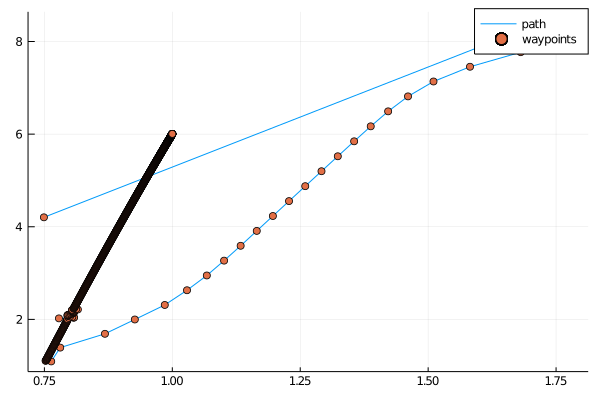

In [24]:
xy = zeros(Integer(length(straight_stop)/kbc.n),2)
waypoints = zeros(Integer(length(straight_stop)/kbc.n),2)

for i=1:Integer(length(straight_stop)/kbc.n)
    xy[i,:] = Z_all[(i-1)*kbc.n+1:(i-1)*kbc.n+2]
    waypoints[i,:] = straight_stop[(i-1)*kbc.n+1:(i-1)*kbc.n+2]
end
plot(xy[:,1], xy[:,2], label="path")
scatter!(waypoints[:,1], waypoints[:,2], label="waypoints")